* If you're running this on Google Colab, please uncomment and run the cell below.

In [ ]:
# !pip install optax
# !pip install flax

In [1]:
%matplotlib inline
import os
import time
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from tqdm import trange
from jax import jvp, value_and_grad
from flax import linen as nn
from typing import Sequence
from functools import partial

## 1. SPINN

In [2]:
# forward function
class SPINN(nn.Module):
    features: Sequence[int]

    @nn.compact
    def __call__(self, x, y, z):
        inputs, outputs = [x, y, z], []
        init = nn.initializers.glorot_normal()
        for X in inputs:
            for fs in self.features[:-1]:
                X = nn.Dense(fs, kernel_init=init)(X)
                X = nn.activation.tanh(X)
            X = nn.Dense(self.features[-1], kernel_init=init)(X)
            outputs += [jnp.transpose(X, (1, 0))]
        xy = jnp.einsum('fx, fy->fxy', outputs[0], outputs[1])
        return jnp.einsum('fxy, fz->xyz', xy, outputs[-1])


# hessian-vector product
def hvp_fwdfwd(f, primals, tangents, return_primals=False):
    g = lambda primals: jvp(f, (primals,), tangents)[1]
    primals_out, tangents_out = jvp(g, primals, tangents)
    if return_primals:
        return primals_out, tangents_out
    else:
        return tangents_out


# loss function
def spinn_loss_klein_gordon3d(apply_fn, *train_data):
    def residual_loss(params, t, x, y, source_term):
        # calculate u
        u = apply_fn(params, t, x, y)
        # tangent vector dx/dx
        # assumes t, x, y have same shape (very important)
        v = jnp.ones(t.shape)
        # 2nd derivatives of u
        utt = hvp_fwdfwd(lambda t: apply_fn(params, t, x, y), (t,), (v,))
        uxx = hvp_fwdfwd(lambda x: apply_fn(params, t, x, y), (x,), (v,))
        uyy = hvp_fwdfwd(lambda y: apply_fn(params, t, x, y), (y,), (v,))
        return jnp.mean((utt - uxx - uyy + u**2 - source_term)**2)

    def initial_loss(params, t, x, y, u):
        return jnp.mean((apply_fn(params, t, x, y) - u)**2)

    def boundary_loss(params, t, x, y, u):
        loss = 0.
        for i in range(4):
            loss += (1/4.) * jnp.mean((apply_fn(params, t[i], x[i], y[i]) - u[i])**2)
        return loss

    # unpack data
    tc, xc, yc, uc, ti, xi, yi, ui, tb, xb, yb, ub = train_data

    # isolate loss function from redundant arguments
    fn = lambda params: residual_loss(params, tc, xc, yc, uc) + \
                        initial_loss(params, ti, xi, yi, ui) + \
                        boundary_loss(params, tb, xb, yb, ub)

    return fn


# optimizer step function
@partial(jax.jit, static_argnums=(0,))
def update_model(optim, gradient, params, state):
    updates, state = optim.update(gradient, state)
    params = optax.apply_updates(params, updates)
    return params, state

## 2. Data generator

In [3]:
# 2d time-dependent klein-gordon exact u
def _klein_gordon3d_exact_u(t, x, y):
    return (x + y) * jnp.cos(2*t) + (x * y) * jnp.sin(2*t)


# 2d time-dependent klein-gordon source term
def _klein_gordon3d_source_term(t, x, y):
    u = _klein_gordon3d_exact_u(t, x, y)
    return u**2 - 4*u


# train data
def spinn_train_generator_klein_gordon3d(nc, key):
    keys = jax.random.split(key, 3)
    # collocation points
    tc = jax.random.uniform(keys[0], (nc, 1), minval=0., maxval=10.)
    xc = jax.random.uniform(keys[1], (nc, 1), minval=-1., maxval=1.)
    yc = jax.random.uniform(keys[2], (nc, 1), minval=-1., maxval=1.)
    tc_mesh, xc_mesh, yc_mesh = jnp.meshgrid(tc.ravel(), xc.ravel(), yc.ravel(), indexing='ij')
    uc = _klein_gordon3d_source_term(tc_mesh, xc_mesh, yc_mesh)
    # initial points
    ti = jnp.zeros((1, 1))
    xi = xc
    yi = yc
    ti_mesh, xi_mesh, yi_mesh = jnp.meshgrid(ti.ravel(), xi.ravel(), yi.ravel(), indexing='ij')
    ui = _klein_gordon3d_exact_u(ti_mesh, xi_mesh, yi_mesh)
    # boundary points (hard-coded)
    tb = [tc, tc, tc, tc]
    xb = [jnp.array([[-1.]]), jnp.array([[1.]]), xc, xc]
    yb = [yc, yc, jnp.array([[-1.]]), jnp.array([[1.]])]
    ub = []
    for i in range(4):
        tb_mesh, xb_mesh, yb_mesh = jnp.meshgrid(tb[i].ravel(), xb[i].ravel(), yb[i].ravel(), indexing='ij')
        ub += [_klein_gordon3d_exact_u(tb_mesh, xb_mesh, yb_mesh)]
    return tc, xc, yc, uc, ti, xi, yi, ui, tb, xb, yb, ub


# test data
def spinn_test_generator_klein_gordon3d(nc_test):
    t = jnp.linspace(0, 10, nc_test)
    x = jnp.linspace(-1, 1, nc_test)
    y = jnp.linspace(-1, 1, nc_test)
    t = jax.lax.stop_gradient(t)
    x = jax.lax.stop_gradient(x)
    y = jax.lax.stop_gradient(y)
    tm, xm, ym = jnp.meshgrid(t, x, y, indexing='ij')
    u_gt = _klein_gordon3d_exact_u(tm, xm, ym)
    t = t.reshape(-1, 1)
    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)
    return t, x, y, u_gt, tm, xm, ym

## 3. Utils

In [4]:
def relative_l2(u, u_gt):
    return jnp.linalg.norm(u-u_gt) / jnp.linalg.norm(u_gt)

def plot_klein_gordon3d(t, x, y, u):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(t, x, y, c=u, s=0.5, cmap='seismic')
    ax.set_title('U(t, x, y)', fontsize=20)
    ax.set_xlabel('t', fontsize=18, labelpad=10)
    ax.set_ylabel('x', fontsize=18, labelpad=10)
    ax.set_zlabel('y', fontsize=18, labelpad=10)
    plt.show()

## 4. Main function

In [5]:
def main(NC, NI, NB, NC_TEST, SEED, LR, EPOCHS, N_LAYERS, FEATURES, LOG_ITER):
    # force jax to use one device
    os.environ["CUDA_VISIBLE_DEVICES"]="0"
    os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"

    # random key
    key = jax.random.PRNGKey(SEED)
    key, subkey = jax.random.split(key, 2)

    # feature sizes
    feat_sizes = tuple(FEATURES for _ in range(N_LAYERS))

    # make & init model
    model = SPINN(feat_sizes)
    params = model.init(subkey, jnp.ones((NC, 1)), jnp.ones((NC, 1)), jnp.ones((NC, 1)))

    # optimizer
    optim = optax.adam(LR)
    state = optim.init(params)

    # dataset
    key, subkey = jax.random.split(key, 2)
    train_data = spinn_train_generator_klein_gordon3d(NC, subkey)
    t, x, y, u_gt, tm, xm, ym = spinn_test_generator_klein_gordon3d(NC_TEST)

    # forward & loss function
    apply_fn = jax.jit(model.apply)
    loss_fn = spinn_loss_klein_gordon3d(apply_fn, *train_data)

    @jax.jit
    def train_one_step(params, state):
        # compute loss and gradient
        loss, gradient = value_and_grad(loss_fn)(params)
        # update state
        params, state = update_model(optim, gradient, params, state)
        return loss, params, state
    
    start = time.time()
    for e in trange(1, EPOCHS+1):
        # single run
        loss, params, state = train_one_step(params, state)
        if e % LOG_ITER == 0:
            u = apply_fn(params, t, x, y)
            error = relative_l2(u, u_gt)
            print(f'Epoch: {e}/{EPOCHS} --> loss: {loss:.8f}, error: {error:.8f}')
    end = time.time()
    print(f'Runtime: {((end-start)/EPOCHS*1000):.2f} ms/iter.')

    print('Solution:')
    u = apply_fn(params, t, x, y)
    plot_klein_gordon3d(tm, xm, ym, u)

## 5. Run!

 50%|█████     | 25121/50000 [00:44<01:27, 284.99it/s]

Epoch: 25000/50000 --> loss: 0.00456247, error: 0.05347236


100%|██████████| 50000/50000 [01:24<00:00, 594.05it/s]


Epoch: 50000/50000 --> loss: 0.00237221, error: 0.01752943
Runtime: 1.68 ms/iter.
Solution:


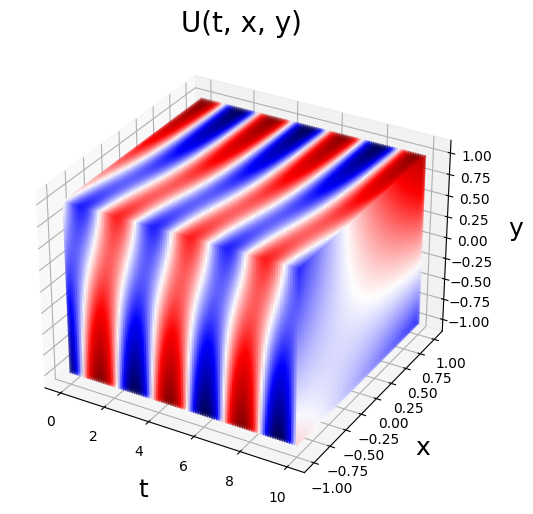

In [6]:
main(NC=64, NI=64, NB=64, NC_TEST=100, SEED=444, LR=1e-3, EPOCHS=50000, N_LAYERS=4, FEATURES=64, LOG_ITER=25000)